<a href="https://colab.research.google.com/github/novais04/GRR-Machine/blob/main/ch03_Classifiacao_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Modelos de Classificação

Neste exemplo, queremos criar um modelo preditivo para responder a uma pergunta. Ele classificará se um indivíduo sobreviveu à catástrofe do navio Titanic com base nas características individuais e da viagem.

# Importação de Biblíotecas e Base

In [235]:
import pandas as pd

# Visualização
import matplotlib.pyplot as plt

#Macchine Learning
from sklearn import ensemble, preprocessing, tree
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve

In [236]:
df = pd.read_csv('https://raw.githubusercontent.com/novais04/GRR-Machine/main/titanic3.csv', sep=';')

In [237]:
orig_df = pd.read_csv('https://raw.githubusercontent.com/novais04/GRR-Machine/main/titanic3.csv', sep=';')

## Limpe dados

In [238]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age           object
sibsp          int64
parch          int64
ticket        object
fare          object
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [239]:
df['age'].replace(',', '.', regex=True, inplace=True)

In [240]:
df['age']=df['age'].astype(float)

In [241]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare          object
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [242]:
df['fare'].replace(',', '.', regex=True, inplace=True)

In [243]:
df['fare'] = df['fare'].astype(float)

In [244]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

##Analise exploratória

In [245]:
#import pandas_profiling

In [246]:
#pandas_profiling.ProfileReport(df)

In [247]:
!pip install sweetviz

In [248]:
import sweetviz as sv

In [249]:
report = sv.analyze(df)

report.show_html("./report_titanic.html")

                                             |          | [  0%]   00:00 -> (? left)

Report ./report_titanic.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [250]:
df.shape

(1309, 14)

In [251]:
df.describe().iloc[:,:2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [252]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [253]:
# verifiando a quantidade de nulos por coluna
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [254]:
# Verificando a média de nulos por coluna
df.isnull().mean()

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

Suposições
- a coluna idade pode ser útil, já que crianças tem prioridade nestes casos.
- Boat, cabin tedem a não ser relevantes --> srão descartadas
- body, além de não ser relevante causa vazamento de informações, pois informa o passageiro que não sobreviveu.
- Boat causa vazamento, porque indica o passageiro que sobreviveu

In [255]:
# Analisando algumas linhas com dados ausentes
mask = df.isnull().any(axis=1)

In [256]:
mask.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [257]:
df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

## Avaliando as colunas do tipo Object
pd.value_counts(dropna=False)

In [258]:
# "dropna=False" inclui os valores NaN em clount
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [259]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

## Crie atributos

In [260]:
name = df.name

In [261]:
name.head(10)

0                      Allen, Miss. Elisabeth Walton
1                     Allison, Master. Hudson Trevor
2                       Allison, Miss. Helen Loraine
3               Allison, Mr. Hudson Joshua Creighton
4    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
5                                Anderson, Mr. Harry
6                  Andrews, Miss. Kornelia Theodosia
7                             Andrews, Mr. Thomas Jr
8      Appleton, Mrs. Edward Dale (Charlotte Lamson)
9                            Artagaveytia, Mr. Ramon
Name: name, dtype: object

In [262]:
# Excuindo as colunas que não vamos trabalhar
df.drop(columns=[
                 'name',
                 'ticket',
                 'home.dest',
                 'boat',
                 'body',
                 'cabin'
                 ],
        inplace = True
        )

In [263]:
#Criando colunas Dummies para sexo e Emabarked
df = pd.get_dummies(df)

In [264]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [265]:
df.drop(columns='sex_male', inplace=True)

In [266]:
df = pd.get_dummies(df, drop_first=True)

In [267]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

## Separe as amostras

### Criando Dataframe de variavel resposta e Variaveis de explicação com __Pyjanitor__

In [268]:
!pip install pyjanitor

In [269]:
import janitor as jn

In [270]:
X, y = jn.get_features_targets(
    df, target_columns="survived"
)

/usr/local/lib/python3.7/dist-packages/janitor/utils.py:309: FutureWarning: get_features_targets() has moved. Please use ml.get_features_targets().
  warnings.warn(message, FutureWarning)


In [271]:
X

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,1
1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,2.0000,1,2,151.5500,1,0,0,1
3,1,30.0000,1,2,151.5500,0,0,0,1
4,1,25.0000,1,2,151.5500,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1304,3,14.5000,1,0,14.4542,1,1,0,0
1305,3,NaN,1,0,14.4542,1,1,0,0
1306,3,26.5000,0,0,7.2250,0,1,0,0
1307,3,27.0000,0,0,7.2250,0,1,0,0


In [272]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Completando os dados
Faça a imputaçao dos dados 

In [273]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute

In [274]:
num_cols = [
    'pclass',
    'age',
    'sibsp', 
    'parch', 
    'fare', 
    'sex_female'
]

In [275]:
imputer = impute.IterativeImputer()

In [276]:
imputed = imputer.fit_transform(X_train[num_cols])

In [277]:
X_train.loc[:,num_cols] = imputed

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [278]:
imputed = imputer.fit_transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [279]:
X_test.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')

# Pré-Processamento
Noramalizando os dados


Traduzir os dados de modo que tenham valor e média igual a 0 e desvio padrão igual a 1.

In [ ]:
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
   'embarked_Q', 'embarked_S']

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)

In [ ]:
X_train = pd.DataFrame(X_train, columns=cols)

In [ ]:
X_test = scaler.fit_transform(X_test)

In [ ]:
X_test = pd.DataFrame(X_test, columns=cols)

## Refatore

- Função para limpeza
- Função para divisão de base teste e treinamento.

In [ ]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ], axis=1
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [ ]:
def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X,y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test    

In [ ]:
ti_df = tweak_titanic(orig_df)

In [ ]:
orig_df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

#Modelos de base
O teorema __“No Free Lunch”__ afirma que nenhum algoritmo tem bom desempenho em todos os dados. No entanto, para um número finito de dados, pode haver um algoritmo que tenha um bom desempenho nesse conjunto.


## Importando biblioteca de desempenho e Função de desempenho


In [281]:
# Métricas de Desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

In [308]:
# Função para cálculo do desempenho de modelos
def calcula_desempenho(modelo, x_train, y_train, x_test, y_test):
    
    # Cálculo dos valores preditos
    ypred_train = modelo.predict(x_train)
    ypred_proba_train = modelo.predict_proba(x_train)[:,1]

    ypred_test = modelo.predict(x_test)
    ypred_proba_test = modelo.predict_proba(x_test)[:,1]

    # Métricas de Desempenho
    acc_train = accuracy_score(y_train, ypred_train)
    acc_test = accuracy_score(y_test, ypred_test)
    
    roc_train = roc_auc_score(y_train, ypred_proba_train)
    roc_test = roc_auc_score(y_test, ypred_proba_test)
    
    ks_train = ks_stat(y_train, ypred_proba_train)
    ks_test = ks_stat(y_test, ypred_proba_test)
    
    prec_train = precision_score(y_train, ypred_train)
    prec_test = precision_score(y_test, ypred_test)
    
    recl_train = recall_score(y_train, ypred_train)
    recl_test = recall_score(y_test, ypred_test)
    
    f1_train = f1_score(y_train, ypred_train)
    f1_test = f1_score(y_test, ypred_test)

    df_desemp = pd.DataFrame({'Treino':[acc_train, roc_train, ks_train, 
                                   prec_train, recl_train, f1_train],
                              'Teste':[acc_test, roc_test, ks_test,
                                       prec_test, recl_test, f1_test]},
                             index=['Acurácia','AUROC','KS',
                                   'Precision','Recall','F1'])
    df_desemp['Variação'] = round(df_desemp['Teste'] / df_desemp['Treino'] - 1, 2)

    return df_desemp

In [ ]:
from sklearn import model_selection




from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

In [ ]:
#Juntado as base

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### Dummy 

In [283]:
from sklearn.dummy import DummyClassifier

In [289]:
# Treinamento do Modelo
modelo_dummy = DummyClassifier()

# Ajuste do Modelo
modelo_dummy.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [290]:
# Desempenho
calcula_desempenho(modelo_dummy, X_train, y_train, X_test, y_test)

,Treino,Teste
Acurácia,0.518559,0.534351
AUROC,0.480037,0.501902
KS,0.039926,0.003804
Precision,0.328125,0.451389
Recall,0.317221,0.384615
F1,0.322581,0.415335


### Regressão Logistica 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#configuração do Modelo
modelo_log = LogisticRegression(random_state=42,
                                fit_intercept=True)

# Ajusta o modelo
modelo_log.fit(X_train,y_train)

In [326]:
#Obtenção dos coeficientes do modelo
print('Intercepto:{}'.format(modelo_log.intercept_))
print('Coeficiente: {}'.format(modelo_log.coef_))

Intercepto:[0.63394965]
Coeficiente: [[-0.77332087 -0.01872525 -0.25611706 -0.08507051  0.00266798  2.45273933
   0.65985512 -0.16084141  0.05485218]]


In [327]:
# Desempenho
calcula_desempenho(modelo_log, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.794760,0.801527,0.01
AUROC,0.832703,0.863258,0.04
KS,0.551316,0.586512,0.06
Precision,0.735974,0.847328,0.15
Recall,0.673716,0.656805,-0.03
F1,0.703470,0.740000,0.05


### Arvore de decisão (PRECISON: 0.868 AUC: 0.841 STD: 0.034)

In [311]:
from sklearn.tree import DecisionTreeClassifier

In [304]:
#configuração do Modelo
modelo_tree = DecisionTreeClassifier(max_depth=3, random_state=42)

# Ajusta modelo
modelo_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

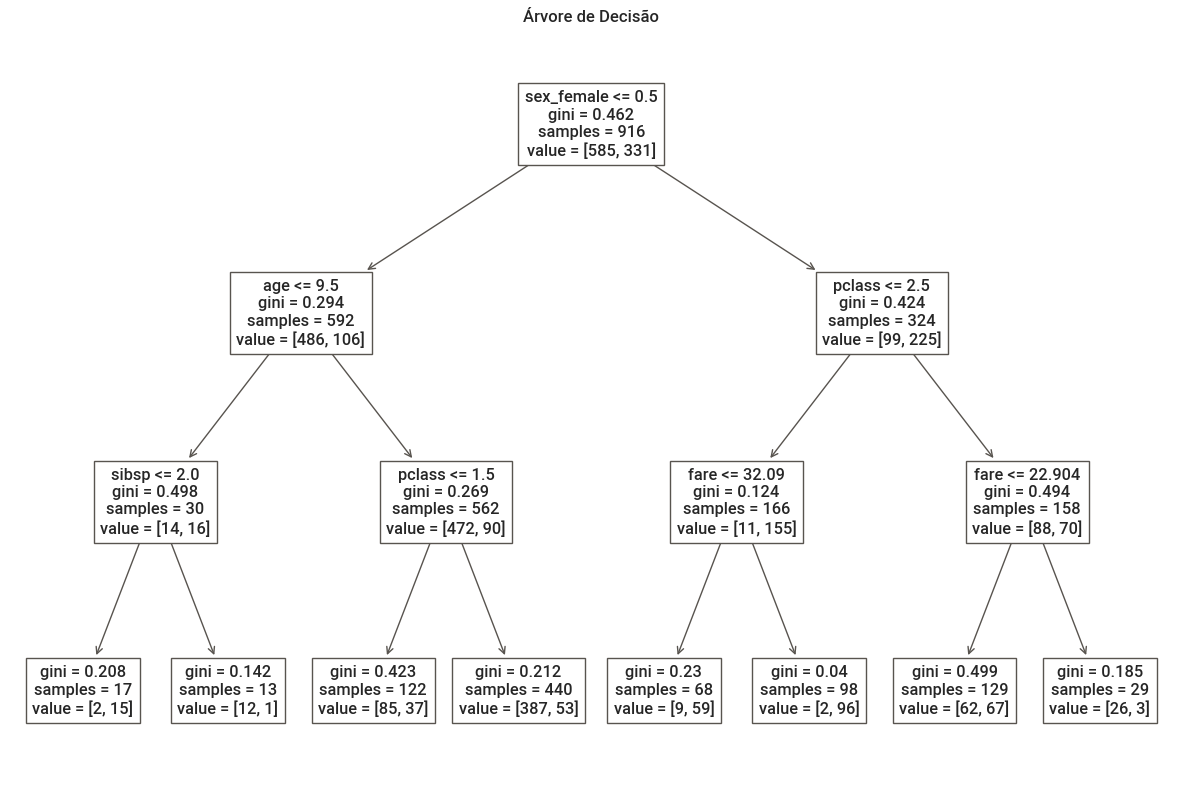

In [305]:
from sklearn import tree

fig = plt.figure(figsize=(15,10))
features = list(X.columns)
tree.plot_tree(modelo_tree,feature_names=features);
plt.title("Árvore de Decisão");

In [310]:
calcula_desempenho(modelo_tree, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.815502,0.814249,-0.00
AUROC,0.850582,0.856892,0.01
KS,0.587807,0.604369,0.03
Precision,0.759615,0.828767,0.09
Recall,0.716012,0.715976,-0.00
F1,0.737170,0.768254,0.04


### Neighbors (PRECISON:  0.0 AUC: 0.0 STD: 0.0

In [312]:
from sklearn.neighbors import KNeighborsClassifier

In [320]:
#configuração do Modelo
modelo_KN = KNeighborsClassifier(n_neighbors=2)

# Ajusta modelo
modelo_KN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [321]:
calcula_desempenho(modelo_KN, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.824236,0.618321,-0.25
AUROC,0.931172,0.626347,-0.33
KS,0.738740,0.216505,-0.71
Precision,0.982955,0.630137,-0.36
Recall,0.522659,0.272189,-0.48
F1,0.682446,0.380165,-0.44


### Naive Bayes

In [322]:
from sklearn.naive_bayes import GaussianNB

In [323]:
#configuração do Modelo
modelo_naive = GaussianNB()

# Ajusta modelo
modelo_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [324]:
calcula_desempenho(modelo_naive, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.788210,0.735369,-0.07
AUROC,0.808250,0.809026,0.00
KS,0.534893,0.534182,-0.00
Precision,0.764479,0.764228,-0.00
Recall,0.598187,0.556213,-0.07
F1,0.671186,0.643836,-0.04
